# PyCoGSS: Spectral Change Analysis of Arctic Water Tracks


```{image} ../thumbnails/nsdf.png
:alt: NSDF logo
:width: 180px
```
```{image} ../thumbnails/pelican.jpeg
:alt: Pelican Platform logo
:width: 100px
:height: 100px
```



## Section 1: Data access through PelicanFS and OSDF

### Overview
This notebook provides an example of a scientific use-case of the PelicanFS framework by accessing data to be analyzed through federated OSDF caches. We use this data to analyze spectral changes of water tracks in a small area of interest in the Arctic. In this analysis we calculate NDVI index which we use to infer the greening and browning trends of the water tracks in the summer months as permafrost thaws. 

We build a dataset from a catalog of open-access Sentinel-2 data from the Amazon Web Service (AWS). Normally, we would access this open data from AWS each time we need to run or re-run our analysis, and each time we would be making requests to the AWS servers. Given the vast spatial, temporal and spectral scale of the satellite data  we use for our analysis, retrieving data can be time and resource costly depending on the infrastructure or network context from which we are performing our computation.  With PelicanFS, we can reduce data acquisition times by performing our catalog search on OSDF federated caches. Additionally, when possible PelicanFS caches data that was previously unavailable in the OSDF cache so that next time we would be able to retrieve it from the cache. Ultimately, we expect that accessing data through PelicanFS will improve the overall time complexity of our analysis workflows.

### Prerequisites

To better understand this notebook, please familiarize yourself with the following concepts:

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to OSDF](http://projectpythia.org/osdf-cookbook/notebooks/osdf-intro/) | Recommended | Overview of OSDF |
| [Overview of FSSpec](https://filesystem-spec.readthedocs.io/en/latest/) | Necessary | To better understand the FSSpec library |
| [Overview of Python xarrays](https://foundations.projectpythia.org/core/xarray/) | Necessary | An introduction to data manipulation using Xarray DataArrays and Datasets |
| [Working with STAC catalogs](https://stacspec.org/en) | Necessary | An overview of SpatioTemporal Asset Catalog (STAC) catalogs for spatial data |
| [Spatial STAC catalogs as xarray data structures](https://stackstac.readthedocs.io/en/latest/); [Working with STAC catalogs in Python](https://pystac-client.readthedocs.io/en/stable/) | Necessary | Efficient computation of spatial raster data as STAC catalogs and xarray data structure in Python |

- **Time to learn**: 30-45 minutes

### Imports

In [1]:
from pelicanfs.core import PelicanFileSystem, PelicanMap,OSDFFileSystem 

import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import numpy as np
import urllib
import re

import geopandas as gpd
import pystac_client 
import stackstac
import rasterio
import shapely
import pyproj


In [2]:
import dask 
from dask_jobqueue import PBSCluster
from dask.distributed import Client as dask_client
from dask.distributed import performance_report

### Build a STAC catalog of Sentinel-2 data from AWS

Here, we begin by building a catalog of Sentinel-2 data that we will access from AWS. The data will be in form of  When we query our catalog, we obtain SPEC metadata objects which we will process further through the PySTAC library. As we see below, our catalog search returned 104 items, where item is a Sentinel-2 scene and take [cite, provide more info for S2 scenes, takes?] matching our AOI for June-October 2020.

In [3]:

# build a geometry of AOI from these coordinate bounds
aoiBounds = (134.66615966473387,  66.82737559988661, 134.72162967387277, 66.85380494758718)
aoiGeom = shapely.geometry.box(*aoiBounds)
lon, lat = 134.70071475239416, 66.84143426792251

startDate      = '2020-06'
endDate       = '2020-08'
# cloudCovMaxPct = 5

catalogURL = 'https://earth-search.aws.element84.com/v1'
search = pystac_client.Client.open(catalogURL).search(collections=['sentinel-2-l2a'],
                                                      # bbox=aoiGeom.bounds,
                                                      datetime=f'{startDate}/{endDate}',
                                                      intersects=dict(type="Point", coordinates=(lon, lat)),
                                                      # query={'eo:cloud_cover': {'lt': cloudCovMaxPct}}
                                                        )


# Get all matching items
items = list(search.items())
print(f'Found {len(items)} matching items.')

Found 104 matching items.


### Pointing STAC catalog to OSDF caches

Now is the time to utilize the capabilities of Pelican File System (PelicanFS) and OSDF caches. Remember that our STAC catalog contains metadata of our data. As mentioned above, each of the 104 items in our catalog is a Sentinel-2 scene for a particular timestamp matching our AOI. We can look up one of the items from the catalog to see its metadata. 


In [4]:
items[0]

<Item id=S2A_53WMQ_20200831_1_L2A>

We can peek further to see where the "assets" of this particular item is store by looking for its URL. As expected the URL points to a AWS bucket somewhere. This checks out, because out STAC catalog is build from Sentinel-2 data store in AWS.

In [6]:
items[0].assets['nir'].href

'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/53/W/MQ/2020/8/S2A_53WMQ_20200831_1_L2A/B08.tif'

Remember we are trying to access our data through PelicanFS, which will hopefully point us to an OSDF cache instead of AWS. If PelicanFS were able to do that, then the URL above would point to an OSDF network of cache resource in some non-AWS server. Now we will prepare to access our data through PelicanFS by first telling PelicanFS where to find Sentinel-2 data in AWS, i.e. pointing it to Sentinel-2 data namespace in AWS. This creates a kind of file path to where OSDF caches data. We will have to do this for each asset URL as seen in the example above. Here is an example of how a new constructed OSDF path from an Asset URL looks like:

In [9]:
def getOSDFPath(url,AWSRegion='us-west-2'):
    """
    Constructs an OSDF path from an asset's original URL.

    Parameters:
    - url: URL to convert.

    Returns:
    - OSDF path.
    """
    
    return f'/aws-opendata/{AWSRegion}/sentinel-cogs{urllib.parse.urlparse(url).path}'


In [10]:
getOSDFPath(items[0].assets['nir'].href)

'/aws-opendata/us-west-2/sentinel-cogs/sentinel-s2-l2a-cogs/53/W/MQ/2020/8/S2A_53WMQ_20200831_1_L2A/B08.tif'

Now let's try accessing this asset through PelicanFS, and opening the retrieved GeoTIFF file using Rasterio.

In [11]:
%%time
pelFS = PelicanFileSystem('pelican://osg-htc.org')
bandUrl = getOSDFPath(items[1].assets['nir'].href, 'us-west-2')
bandDS = rasterio.open(bandUrl, opener=pelFS)
bandDS.close()

Discovery URL pelican://osg-htc.org/ does not match pelican://test/


CPU times: user 169 ms, sys: 31.4 ms, total: 200 ms
Wall time: 9.51 s


So we are able to read the raster through the PelicanFS using Rasterio. Let's probe further to see which OSDF caches PelicanFS is routing us to!

In [9]:
pelFS._access_stats.get_responses(bandUrl)[0][-1].access_path

'https://osdf1.newy32aoa.nrp.internet2.edu:8443/aws-opendata/us-west-2/sentinel-cogs/sentinel-s2-l2a-cogs/53/W/MQ/2020/8/S2A_53WMQ_20200831_0_L2A/B08.tif'

Now we'll pull a small trick and try to find out which OSDF resource PelicanFS found the cache, i.e. our raster file. This is helpful for us, because now we can easily point PelicanFS to this resource for all our items in our catalog. Why are we doing this? We see that reading a single item's asset takes ~8 seconds, ans since we have 104 items, and for each item we intend to read assets (the Red, NIR and SCL bands), it means ~24 seconds for each item, and $104 \times 24 = 2496$ for all items in the catalog. About 42 minutes in total, with potential additional network overhead time costs!

Now we will point all the URLs in our cache to ``
https://osdf1.newy32aoa.nrp.internet2.edu:8443``, and hopefully PelicanFS will find them there!

In [13]:
%%time

import warnings
warnings.filterwarnings('ignore')

pelFS = PelicanFileSystem('pelican://osg-htc.org')

itemsOSDFCache = items
for idx, item in enumerate(items): # start=1):
    # print(f'Processing dataset #{idx}')

    cacheCount = 0
    for band in ['red','nir','scl']:
        bandUrl = getOSDFPath(items[idx].assets[band].href)
        
        # takes too long to access cache through PelicanFS unfortunately
        # we can do a sneak peak of one of the items to see the OSDF location 
        # from which PelicanFS finds its cache then point the rest of our catalog to it!
        '''
        bandDS = rasterio.open(bandUrl, opener=pelFS)
        if pelFS._access_stats.get_responses(bandUrl)[1]:
            osdfCachePath = pelFS._access_stats.get_responses(bandUrl)[0][-1].access_path
            # print(f'cache for dataset #{idx} found in {osdfCachePath} \n')
            items[idx].assets[band].href = pelFS._access_stats.get_responses(bandUrl)[0][-1].access_path
            cacheCount += 1
        # close dataset!
        bandDS.close()
        '''
        itemsOSDFCache[idx].assets[band].href = 'https://osdf1.newy32aoa.nrp.internet2.edu:8443'+bandUrl
    
    # print(f'{cacheCount} caches found for dataset #{idx} \n')
    

CPU times: user 2.33 ms, sys: 0 ns, total: 2.33 ms
Wall time: 2.35 ms


Inspecting one of the items shows the that its assets point to the new OSDF URL!

In [14]:
items[23].assets['nir'].href

'https://osdf1.newy32aoa.nrp.internet2.edu:8443/aws-opendata/us-west-2/sentinel-cogs/sentinel-s2-l2a-cogs/53/W/MQ/2020/8/S2A_53WMQ_20200811_0_L2A/B08.tif'

### Stacking STAC into lazy xarray objects

Now is the time to turn our "OSDF catalog" into data that we can analyze. We'll do so by using the ``stackstac`` library to convert the STAC catalog to xarray data structures, and makes it possible to perform distributed computing with the help of dask. In any case, the resulting xarray data structures will be lazy, meaning that data is not loaded upfront, but only when needed. Because we have a large dataset [cite: compute size], lazy loading will be really helpful to optimize our resource usage. 

In [15]:
%%time
s2Stack = stackstac.stack(itemsOSDFCache, assets=['red', 'nir', 'scl'],
                         bounds = aoiGeom.bounds,
                          gdal_env=stackstac.DEFAULT_GDAL_ENV.updated(
                               {'GDAL_HTTP_MAX_RETRY': 3,
                                'GDAL_HTTP_RETRY_DELAY': 5,
                               }),
                          epsg=4326,
                              #    chunksize=(1, 1, 50, 50) # Original - many small chunks bad for plotting
                                 chunksize=(1, -1, 100, 100)
                                ).rename(
       {'x': 'lon', 'y': 'lat'}).to_dataset(dim='band')
s2Stack

CPU times: user 176 ms, sys: 18.9 ms, total: 195 ms
Wall time: 224 ms


<xarray.Dataset> Size: 872MB
Dimensions:                                  (time: 104, lat: 416, lon: 840,
                                              band: 3)
Coordinates: (12/51)
  * time                                     (time) datetime64[ns] 832B 2020-...
    id                                       (time) <U24 10kB 'S2A_53WMQ_2020...
  * lon                                      (lon) float64 7kB 134.7 ... 134.7
  * lat                                      (lat) float64 3kB 66.85 ... 66.83
    s2:dark_features_percentage              (time) object 832B 5.478115 ... ...
    s2:datastrip_id                          (time) <U64 27kB 'S2A_OPER_MSI_L...
    ...                                       ...
    title                                    (band) <U30 360B 'Red (band 4) -...
    raster:bands                             (band) object 24B None ... [{'no...
    common_name                              (band) object 24B 'red' 'nir' None
    center_wavelength                        (band) object 24B 0.665 0.842 None
    full_width_half_max                      (band) object 24B 0.038 0.145 None
    epsg                                     int64 8B 4326
Dimensions without coordinates: band
Data variables:
    red                                      (time, lat, lon) float64 291MB dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    nir                                      (time, lat, lon) float64 291MB dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    scl                                      (time, lat, lon) float64 291MB dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
Attributes:
    spec:           RasterSpec(epsg=4326, bounds=(134.66612907013848, 66.8273...
    crs:            epsg:4326
    transform:      | 0.00, 0.00, 134.67|\n| 0.00,-0.00, 66.85|\n| 0.00, 0.00...
    resolution_xy:  (6.612317572720078e-05, 6.372865585874454e-05)

## Section 2: NDVI analysis of water tracks and inter-tracks

Now we can continue our analysis!

### Calculate NDVI

In [17]:
zeroMask = s2Stack['nir'] + s2Stack['red']

s2Stack['ndvi'] = (s2Stack.where(zeroMask != 0, np.nan)['nir'] - s2Stack.where(zeroMask != 0, np.nan)['red'])/\
                        (s2Stack.where(zeroMask != 0, np.nan)['nir'] + s2Stack.where(zeroMask != 0, np.nan)['red'])

# # Only keep ndvi and classification, but know you can save things like 'visible' or other fun rasters!
s2Stack = s2Stack[['ndvi', 'scl']]
s2Stack = s2Stack.drop_vars([c for c in s2Stack.coords if not (c in ['time', 'lat', 'lon'])])
s2Stack

<xarray.Dataset> Size: 581MB
Dimensions:  (time: 104, lat: 416, lon: 840)
Coordinates:
  * time     (time) datetime64[ns] 832B 2020-06-02T02:39:04.253000 ... 2020-0...
  * lon      (lon) float64 7kB 134.7 134.7 134.7 134.7 ... 134.7 134.7 134.7
  * lat      (lat) float64 3kB 66.85 66.85 66.85 66.85 ... 66.83 66.83 66.83
Data variables:
    ndvi     (time, lat, lon) float64 291MB dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    scl      (time, lat, lon) float64 291MB dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
Attributes:
    spec:           RasterSpec(epsg=4326, bounds=(134.66612907013848, 66.8273...
    crs:            epsg:4326
    transform:      | 0.00, 0.00, 134.67|\n| 0.00,-0.00, 66.85|\n| 0.00, 0.00...
    resolution_xy:  (6.612317572720078e-05, 6.372865585874454e-05)

### Test on the centroid

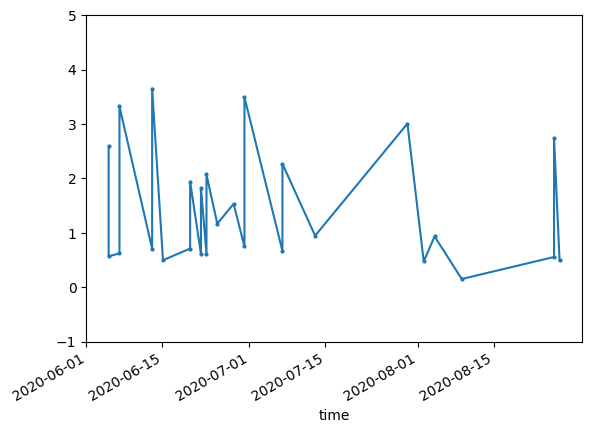

CPU times: user 17.7 s, sys: 1.18 s, total: 18.8 s
Wall time: 38.1 s


In [19]:
%%time
s2Point = s2Stack.interp(lat=lat, lon=lon,method='nearest')

s2Df = s2Point.to_dataframe()
s2DfFilt = s2Df[(s2Df['scl'] == 4) | (s2Df['scl'] == 5)]

fig, ax = plt.subplots()
s2DfFilt['ndvi'].plot(label='unfiltered',
                      marker='o', 
                      # linestyle='--',
                      markersize=2, ax=ax)
ax.set_ylim(-1.0,5.0)
plt.show()

Fascinating. What happened in late July, early August 2020? Let's take a look at an asset from the collection during that time period.

In [20]:
pics = {}
from datetime import datetime
for item in items:
    item_dict = {}
    item_dict['date'] = item.properties['datetime']
    item_dict['pic'] = item.assets['visual'].href
    item_dict['thumb'] = item.assets['thumbnail'].href
    pics[item.id] = item_dict

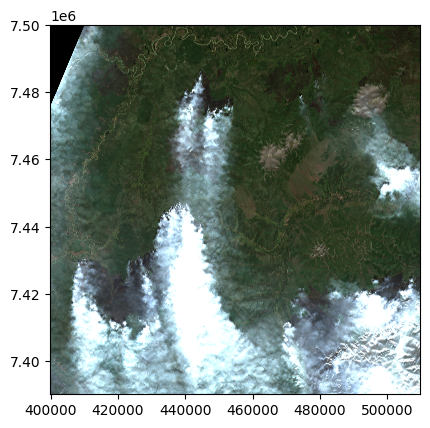

CPU times: user 15.4 s, sys: 2.32 s, total: 17.7 s
Wall time: 35.9 s


In [54]:
%%time
from rasterio.plot import show
with rasterio.open(pics['S2A_53WMQ_20200804_1_L2A']['pic']) as dataset:
    show(dataset)

That'll do it! (this is a fire burning the larch forests of the eastern Siberia taiga)

### Plot the whole stack?

#### Mosaic by date

In [14]:
s2StackMosaic = s2Stack.groupby('time.date').median(dim='time')
# s2StackMosaic = sentinel_stack_mosaicked.rename({'date': 'time'})
# sentinel_stack_mosaicked['time'] = sentinel_stack_mosaicked['time'].astype('datetime64[ns]')

Day of year makes it easier for a linear trend analysis!

In [15]:
day_of_year = xr.DataArray(
    s2StackMosaic['date'].astype('datetime64[ns]').dt.dayofyear,
    coords={'date': s2StackMosaic['date']},
    dims='date',
    name='day_of_year'
)

s2StackMosaic = s2StackMosaic.assign_coords({'day_of_year': day_of_year})
s2StackMosaic

<xarray.Dataset> Size: 302MB
Dimensions:      (date: 54, lat: 416, lon: 840)
Coordinates:
  * lon          (lon) float64 7kB 134.7 134.7 134.7 134.7 ... 134.7 134.7 134.7
  * lat          (lat) float64 3kB 66.85 66.85 66.85 66.85 ... 66.83 66.83 66.83
  * date         (date) object 432B 2020-06-02 2020-06-03 ... 2020-08-31
    day_of_year  (date) int64 432B 154 155 157 159 160 ... 237 239 240 242 244
Data variables:
    ndvi         (date, lat, lon) float64 151MB dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    scl          (date, lat, lon) float64 151MB dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
Attributes:
    spec:           RasterSpec(epsg=4326, bounds=(134.66612907013848, 66.8273...
    crs:            epsg:4326
    transform:      | 0.00, 0.00, 134.67|\n| 0.00,-0.00, 66.85|\n| 0.00, 0.00...
    resolution_xy:  (6.612317572720078e-05, 6.372865585874454e-05)

Now we can look at cool pictures by date

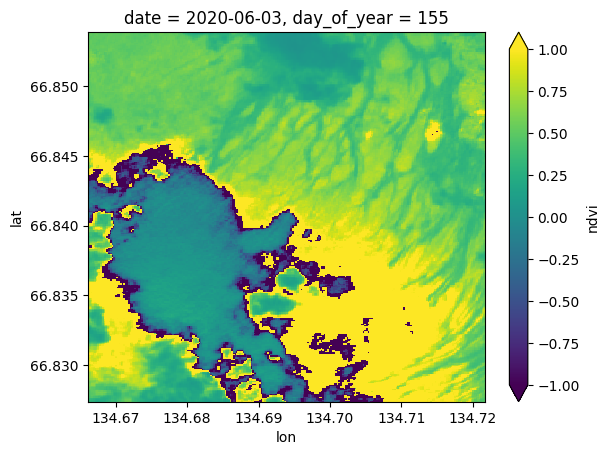

In [16]:
s2StackMosaic['ndvi'][1].plot.imshow(vmin=-1.0, vmax=1.0)

In [55]:
s2StackMosaic['ndvi'][5]

<xarray.DataArray 'ndvi' (lat: 416, lon: 840)> Size: 3MB
dask.array<getitem, shape=(416, 840), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>
Coordinates:
  * lon          (lon) float64 7kB 134.7 134.7 134.7 134.7 ... 134.7 134.7 134.7
  * lat          (lat) float64 3kB 66.85 66.85 66.85 66.85 ... 66.83 66.83 66.83
    date         object 8B 2020-06-10
    day_of_year  int64 8B 162

#### Mask out undesireable pixels in the stack according to the scene classification layer

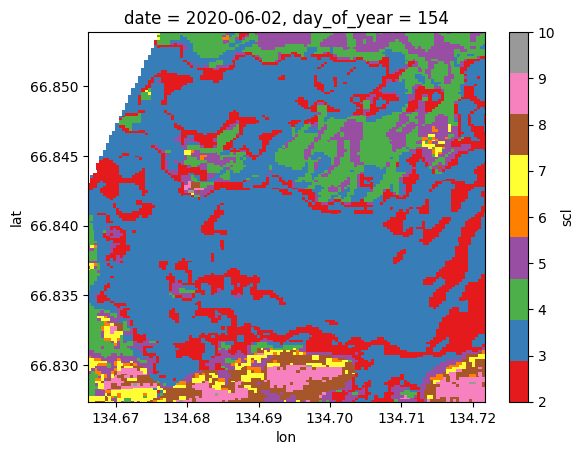

In [56]:
s2StackMosaic['scl'][0].plot.imshow(cmap='Set1')

Google 'sentinel 2 scene classification layer'. You'll see that 4 and 5 are coded for vegetated and not vegetated. Conservatively, everything else is trash for interpreting NDVI.

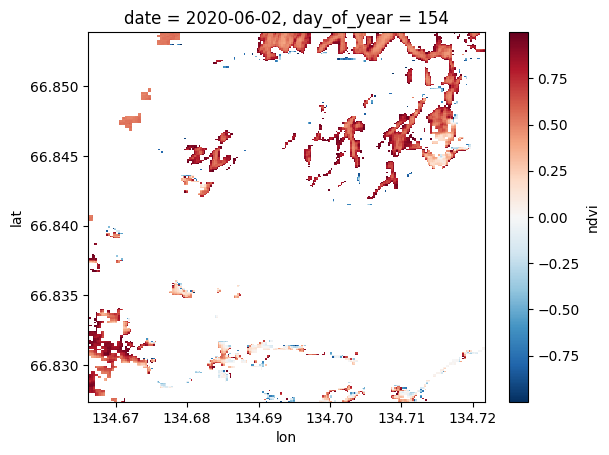

In [57]:
ndviMasked = s2StackMosaic['ndvi'].where(s2StackMosaic['scl'].isin([4, 5]))

ndviMasked = ndviMasked.where(ndviMasked >= -1.0)

ndviMasked = ndviMasked.where(ndviMasked <= 1.0)

ndviMasked[0].plot.imshow(
    # vmin=-1.0, vmax=1.0
)

Ah yes, that's better.

In [58]:
%%time
meanNDVIDoY = ndviMasked.mean(dim=['lat', 'lon'], skipna=True).to_dataframe(name='mean_ndvi').reset_index()
meanNDVIDoY.head()

CPU times: user 39.3 s, sys: 1.67 s, total: 41 s
Wall time: 51.1 s


,date,day_of_year,mean_ndvi
0,2020-06-02,154,0.540790
1,2020-06-03,155,0.868504
2,2020-06-05,157,0.742032
3,2020-06-07,159,0.665262
4,2020-06-08,160,-0.370471


<Axes: xlabel='day_of_year', ylabel='mean_ndvi'>

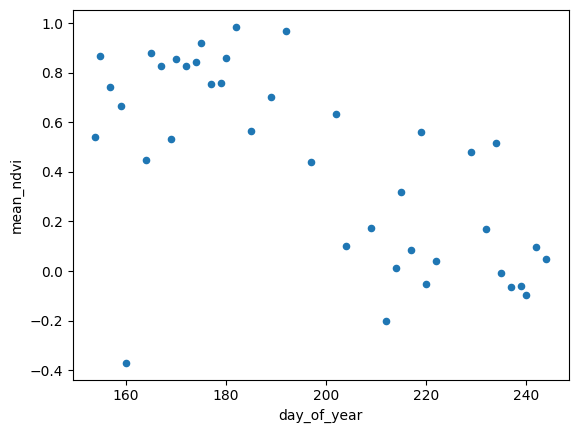

In [59]:
meanNDVIDoY.plot.scatter(x='day_of_year', y='mean_ndvi')

OK, cute. So detecting this somehow automatically and then cross-referencing this against some climate data would be cool (in this case it's burned, not climate, which are related but also maybe checking against some fire database or product too).

### Do a trendline fit

What if we could visualize the pixelwise trend in greening and browning over a season? Let's take a linear trend for each pixel's NDVI across the year (hence why day of year is a useful variable here).

CPU times: user 1min 7s, sys: 2.02 s, total: 1min 10s
Wall time: 1min 20s


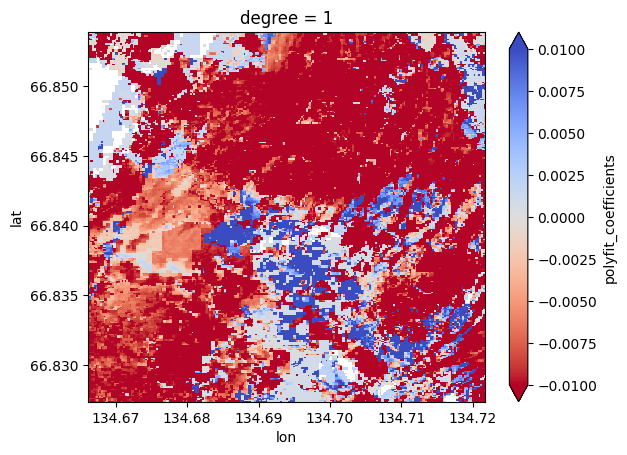

In [60]:
%%time
fit = ndviMasked.polyfit(dim='day_of_year', deg=1)
slopes = fit['polyfit_coefficients'].sel(degree=1)

slopes.plot.imshow(
                cmap='coolwarm_r',
                vmin=-.01,
                vmax=.01)


This is now a great raster to play around with in GIS if you choose. A lot of those red streaks are the flowpaths we're intersted in (water tracks) so it's interesting that they got browner over the growing season compared to the intertrack areas which are generally positive (got greener over the growing season). 

In [66]:
slopes.rio.set_spatial_dims(x_dim='lon', y_dim='lat', inplace=True)
slopes.rio.write_crs('EPSG:4326', inplace=True)
# slopes.rio.to_raster('ndvi_masked_trend.tif')


<xarray.DataArray 'polyfit_coefficients' (lat: 416, lon: 840)> Size: 3MB
dask.array<getitem, shape=(416, 840), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>
Coordinates:
    degree       int64 8B 1
  * lon          (lon) float64 7kB 134.7 134.7 134.7 134.7 ... 134.7 134.7 134.7
  * lat          (lat) float64 3kB 66.85 66.85 66.85 66.85 ... 66.83 66.83 66.83
    spatial_ref  int64 8B 0